# Connecting

In [1]:
%config Completer.use_jedi = False

In [2]:
import os

# setting working dir
os.chdir("../src")

In [3]:
from elasticsearch_db.elasticsearch import elastic_conection
from elasticsearch_db.elasticsearch import get_nlp_model

es = elastic_conection()

In [4]:
workspace_id = "dc1e7b3d-9137-4a20-a99c-d0d2029ef170"
workspace, exist = get_nlp_model(es, workspace_id=workspace_id)
exist

True

# Data Sourcing

In [5]:
from data_pipeline.data_sourcing import get_data

#get_data?

In [16]:
df = get_data(workspace=workspace, es=es)
df.head()

,intents,examples
0,Inativar_Posição,Como realizo a inativação de uma posição de mi...
1,Inativar_Posição,Como realizo a reativação de uma posição em mi...
2,Inativar_Posição,Em quanto tempo a inativação de uma posição é ...
3,Inativar_Posição,"Gostaria de fazer a inativação de uma posição,..."
4,Inativar_Posição,Realizei a inativação de uma posição e ela con...


# Data Preprocessing

### Create artificial Examples

In [7]:
# from data_pipeline.data_preprocessing import fill_missing_examples

# fill_missing_examples?

In [8]:
# data = fill_missing_examples(data)

### Cleansing

In [9]:
from data_pipeline.data_preprocessing import clean_examples

#clean_examples?

In [17]:
df = clean_examples(df)

In [18]:
df.head()

,intents,examples,cleaned_examples
0,Inativar_Posição,Como realizo a inativação de uma posição de mi...,realiz inativ pos estrut
1,Inativar_Posição,Como realizo a reativação de uma posição em mi...,realiz reativ pos estrut
2,Inativar_Posição,Em quanto tempo a inativação de uma posição é ...,quant temp inativ pos efetiv
3,Inativar_Posição,"Gostaria de fazer a inativação de uma posição,...",gost faz inativ pos fac
4,Inativar_Posição,Realizei a inativação de uma posição e ela con...,realiz inativ pos continu vis


# Feature Extracting

In [19]:
from data_pipeline.feature_extracting import encode_features

df, x_transformer = encode_features(df)
df.head(2)

,intents,examples,cleaned_examples,13o,1a,2808sem,2k,2o,abaix,abat,...,vou,vr,vtnc,word,workflow,wwwpremiertravelc,xau,yar,yarin,zacarin
0,Inativar_Posição,Como realizo a inativação de uma posição de mi...,realiz inativ pos estrut,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Inativar_Posição,Como realizo a reativação de uma posição em mi...,realiz reativ pos estrut,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Data Splitting

In [20]:
from data_pipeline.data_splitting import split

# data_splitting?

In [21]:
X_train, X_test, y_train, y_test = split(df)

In [23]:
X_train.shape

(817, 1174)

In [24]:
y_train.shape

(817,)

# Feature Extracting

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def encode_features(train, test):
    all_examples = train.examples.to_list() + test.examples.to_list()
    transformer = TfidfVectorizer()
    transformer.fit(all_examples)
    
    train_matrix = transformer.transform(train.examples.to_list()).toarray()
    test_matrix = transformer.transform(test.examples.to_list()).toarray()
    train["tfidf_vectors"] = [row for row in train_matrix]
    test["tfidf_vectors"] = [row for row in test_matrix]
    df1 = pd.DataFrame(x.toarray(), columns=v.get_feature_names())
    
    return train, test, transformer

# Scikit Learn Pipe Line

In [15]:
# from sklearn.compose import make_column_transformer
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

# Training

#### Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import numpy as np


def train_logreg(X, y, **hyper_parameters):
    logreg = LogisticRegression(
                    multi_class="multinomial",
                    n_jobs=-1,
                    **hyper_parameters
        )
        
    model = Pipeline(
                steps= [
                    ('text_features', TfidfVectorizer()),
                    ('model', logreg)
                ]
            )
#     regr = TransformedTargetRegressor(regressor=model,
#                                    transformer=LabelEncoder())
    model.fit(X, y)
    return model

In [20]:
hyper_parameters = {
          "C": 5,
          "fit_intercept": False,
          "random_state": 1,
          "max_iter": 1000
        }

logreg_clf = train_logreg(
                    X=train.example_text, 
                    y=train.intent_name,
                    **hyper_parameters
            )

In [21]:
y_pred = logreg_clf.predict(test.example_text)
np.sum((y_pred == test.intent_name)) / test.shape[0]

0.6876122082585279

In [22]:
logreg_clf.predict_proba(test.example_text)

array([[0.00250424, 0.00247818, 0.00235277, ..., 0.00357567, 0.00247282,
        0.00251013],
       [0.00306973, 0.00302721, 0.00284464, ..., 0.00470976, 0.00305399,
        0.00308157],
       [0.00146732, 0.00145828, 0.00136347, ..., 0.00218647, 0.00143466,
        0.00187453],
       ...,
       [0.00292498, 0.00295398, 0.00293895, ..., 0.00369217, 0.00293383,
        0.26013481],
       [0.0025255 , 0.00254619, 0.0031367 , ..., 0.00250099, 0.00252309,
        0.40970458],
       [0.00226739, 0.00232928, 0.00226232, ..., 0.00290553, 0.00223531,
        0.36142497]])

#### SVM

In [23]:
from sklearn import svm

def train_svm(X, y, **hyper_parameters):
    poly_svm = svm.SVC(
                    kernel="poly", 
                    probability=True,
                    **hyper_parameters
              )
        
    model = Pipeline(
                steps= [
                    ('text_features', TfidfVectorizer()),
                    ('model', poly_svm)
                ]
            )
    model.fit(X, y)
    return model

In [24]:
hyper_parameters = {
          "degree": 1,
          "coef0": 0,
          "random_state": 42
        }
svm_clf = train_svm(
                X=train.example_text, 
                y=train.intent_name,
                **hyper_parameters
            )

In [25]:
y_pred = svm_clf.predict(test.example_text)
np.sum((y_pred == test.intent_name)) / test.shape[0]

0.6624775583482945

In [26]:
svm_clf.named_steps["text_features"].get_feature_names()[100:120]

['ant',
 'anteri',
 'antig',
 'aond',
 'aparec',
 'aparelh',
 'apen',
 'aplic',
 'apos',
 'app',
 'apres',
 'apresent',
 'aprov',
 'aproveit',
 'apur',
 'aqu',
 'are',
 'arquiv',
 'asat',
 'assalt']

In [27]:
train.intent_name.nunique()

206

#### Neural Network

In [30]:
from sklearn.base import RegressorMixin, BaseEstimator, clone
import tensorflow as tf

class MyTransformedTargetRegressor(BaseEstimator, RegressorMixin):

    def __init__(self, regressor, transformer):
        self.regressor = regressor
        self.transformer = transformer

    def fit_transformer(self, y):
        self.transformer_ = clone(self.transformer)
        self.transformer_.fit(y)
        return self

    def fit(self, X, y, **fit_params):

        # store the number of dimension of the target to predict an array of
        # similar shape at predict
        y = y.to_numpy()
        self._training_dim = y.ndim

        # transformers are designed to modify X which is 2d dimensional, we
        # need to modify y accordingly.
       
        y_2d = y.reshape(-1, 1)
        
            
        self.fit_transformer(y_2d)
        y_trans = self.transformer_.transform(y_2d)

        self.regressor_ = clone(self.regressor)

        history = self.regressor_.fit(X, y_trans, **fit_params)

        return history

    def predict(self, X):
        check_is_fitted(self)
        pred = self.regressor_.predict(X)
        if pred.ndim == 1:
            pred_trans = self.transformer_.inverse_transform(
                pred.reshape(-1, 1))
        else:
            pred_trans = self.transformer_.inverse_transform(pred)
        if (self._training_dim == 1 and
                pred_trans.ndim == 2 and pred_trans.shape[1] == 1):
            pred_trans = pred_trans.squeeze(axis=1)

        return pred_trans
    
    def predict_proba(self, X):
        pred = self.regressor_.predict_proba(X)
        return pred

    def _more_tags(self):
        return {'poor_score': True, 'no_validation': True}

In [31]:
from sklearn.base import TransformerMixin, BaseEstimator, clone
import numpy as np

class MyTfidfVectorizer(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.transformer = TfidfVectorizer()


    def fit(self, X, y=None):
        examples = X.to_list()
        self.transformer_ = clone(self.transformer)
        self.transformer_.fit(examples)

        return self
    
    def transform(self, X, y=None):
        examples = X.to_list()
        features = self.transformer_.transform(examples)
        tfidf_matrix = np.stack(features.toarray())
        return tfidf_matrix

In [35]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.compose import TransformedTargetRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

all_data = pd.concat([train, test], ignore_index=True)

global learning_rate; learning_rate = 0.001
global loss; loss = "categorical_crossentropy"
global number_of_intent_classes 
number_of_intent_classes = all_data.intent_name.nunique()
n_features = len(svm_clf.named_steps["text_features"].get_feature_names())
global input_shape; input_shape = (n_features,)

# Keras Model
def build_nn(**hyper_parameters):
    model = Sequential()
    model.add(
            Dense(
                units=input_shape[0],
                activation="relu",
                input_shape=input_shape,
                name="input_layer",
            )
    )
    model.add(Dense(units=input_shape[0], activation="relu", name="layer_2"))
    # Output
    model.add(
        Dense(units=number_of_intent_classes, activation="softmax", name="output_layer")
    )

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=loss,
        metrics=["accuracy"]
    )
    return model


def train_nn(X, y, **hyper_parameters):
    nn = KerasClassifier(build_fn=build_nn,
                          **hyper_parameters)
    nn._estimator_type = "classifier"
    model = Pipeline(
                steps= [
                    ('text_features', MyTfidfVectorizer()),
                    ('model', nn)
                ]
            )
    regres = MyTransformedTargetRegressor(
                                regressor=model,
                                transformer=OneHotEncoder(sparse=False)
            )
    regres.fit(X, y, validation_split=0.2);
    return regres

In [38]:
import pandas as pd

hyper_parameters = {
  "epochs": 5,
  "verbose":True,
  "batch_size": 50,
  "validation_split":0.33
}

all_data = pd.concat([train, test], ignore_index=True)

nn_clf = train_nn(
                X=all_data.example_text, 
                y=all_data.intent_name,
                **hyper_parameters
          )

Epoch 1/5


ValueError: in user code:

    /usr/local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /usr/local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /usr/local/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /usr/local/lib/python3.6/site-packages/tensorflow/python/keras/engine/input_spec.py:259 assert_input_compatibility
        ' but received input with shape ' + display_shape(x.shape))

    ValueError: Input 0 of layer sequential_2 is incompatible with the layer: expected axis -1 of input shape to have value 1077 but received input with shape (None, 1258)


In [34]:
history

Pipeline(steps=[('text_features', MyTfidfVectorizer()),
                ('model',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f743b0b3278>)])

# Train ensemble

#### Voting

In [198]:
from sklearn.ensemble import VotingClassifier

def train_voting(X_train, y_train, estimators, weights, **kwargs):
    meta_model = VotingClassifier(
                        estimators=estimators,
                        weights=weights,
                        **kwargs)
#     model = TransformedTargetRegressor(
#                                 regressor=meta_model,
#                                 transformer=IndexLabelEncode(y=y)
#             )
    meta_model.fit(X_train, y_train)
    return meta_model


estimators = [('clf1', logreg_clf), 
              ('clf2', svm_clf),
              ('clf3', nn_clf)]
weights = [0.6929982046678635, 0.6427289048473968, 0.6894075274467468]
voting = train_voting(train.example_text, train.intent_name, 
                      estimators, 
                      weights,
                      voting='soft',
                      flatten_transform=True,
                      n_jobs=-1)
y_pred = voting.predict(X_test)
accuracy = np.sum((y_pred == y_test).all(1)) / y_test.shape[0]
accuracy

ValueError: The estimator MyTransformedTargetRegressor should be a classifier.

# Prefect

In [1]:
import os

# setting working dir
os.chdir("../src")

from prefect import Flow, task, context

from data_pipeline.data_sourcing import get_data
from data_pipeline.data_preprocessing import fill_missing_examples, clean_examples
from data_pipeline.feature_engineering import intents_to_onehot, create_corpus, encode_features
from data_pipeline.data_splitting import data_splitting
from elasticsearch_db.elasticsearch import elastic_conection
from elasticsearch_db.elasticsearch import get_nlp_model

es = elastic_conection()
workspace_id = "dc1e7b3d-9137-4a20-a99c-d0d2029ef170"
workspace, exist = get_nlp_model(es, workspace_id=workspace_id)
exist

True

In [2]:
@task
def sourcing(workspace, es):

    return get_data(
                workspace=workspace, 
                es=es
            )

@task
def imputation(data):
    
    return fill_missing_examples(data)

@task
def cleansing(data):

    return clean_examples(data)

@task(nout=2)
def splitting(data):

    return data_splitting(data)

@task(nout=4)
def encoding(train, test):
    all_intents = set([example[0] for example in train])
    map_onehot, intent_dictionary = intents_to_onehot(
                                        intents_name=all_intents
                                    )
    all_examples = [example[0] for example in train] + \
                   [example[0] for example in test]
        
    corpus = create_corpus(examples_text=all_examples)
    
    X_train, y_train, X_test, y_test = encode_features(
                                            train=train, 
                                            test=test, 
                                            corpus=corpus, 
                                            map_onehot=map_onehot
                                    )
    return X_train, y_train, X_test, y_test

In [3]:
# Define prefect flow
with Flow("train_dataflow") as flow:

    data = sourcing(workspace=workspace, es=es)
    data = imputation(data=data)
    data = cleansing(data=data)
    train, test = splitting(data=data)
    X_train, y_train, X_test, y_test = encoding(train=train, 
                                                test=test)

[2021-04-21 12:08:00+0000] INFO - prefect.FlowRunner | Beginning Flow run for 'train_dataflow'
[2021-04-21 12:08:01+0000] INFO - prefect.TaskRunner | Task 'sourcing': Starting task run...
[2021-04-21 12:08:01+0000] INFO - prefect.TaskRunner | Task 'sourcing': Finished task run for task with final state: 'Success'
[2021-04-21 12:08:01+0000] INFO - prefect.TaskRunner | Task 'imputation': Starting task run...
[2021-04-21 12:08:21+0000] INFO - prefect.TaskRunner | Task 'imputation': Finished task run for task with final state: 'Success'
[2021-04-21 12:08:21+0000] INFO - prefect.TaskRunner | Task 'cleansing': Starting task run...
[2021-04-21 12:08:22+0000] INFO - prefect.TaskRunner | Task 'cleansing': Finished task run for task with final state: 'Success'
[2021-04-21 12:08:22+0000] INFO - prefect.TaskRunner | Task 'splitting': Starting task run...
[2021-04-21 12:08:22+0000] INFO - prefect.TaskRunner | Task 'splitting': Finished task run for task with final state: 'Success'
[2021-04-21 12:08

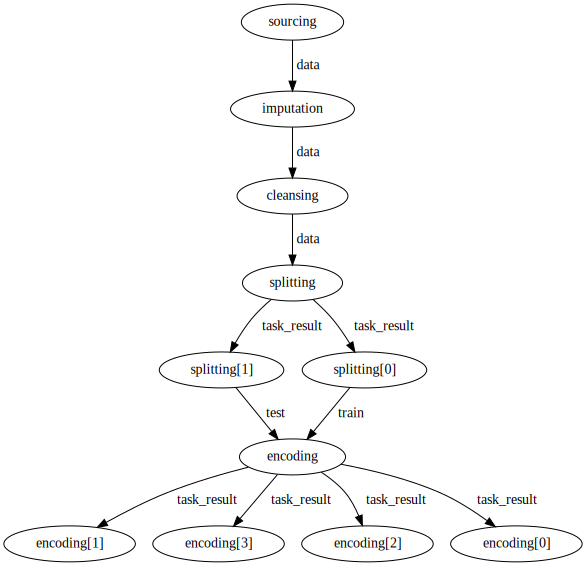

In [4]:
# Run prefect flow
flow.run()

# Export flow as a PDF
flow.visualize(filename="../src/data_pipeline/flow_diagrams/train_dataflow")